In [1]:
import sys
print(sys.version)
import numpy as np
import oommfpy
from oommfpy import OOMMFODTReader

print(f"OOMMFPy 版本: {oommfpy.__version__}")
print(f"Numpy 版本: {np.__version__}")

# 这是一个简单的检查命令
try:
    # 尝试创建一个读取器对象（即使不输入文件）
    reader = OOMMFODTReader
    print("✅ 库导入正常，可以开始处理数据了！")
except Exception as e:
    print(f"❌ 导入仍有异常: {e}")

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
OOMMFPy 版本: 1.4
Numpy 版本: 2.4.2
✅ 库导入正常，可以开始处理数据了！


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob, os
import oommfpy as op
from tqdm import tqdm  # 用于显示进度条

# --- 配置 ---
data_dir = r'D:\oommf21a2\sw_diffraction'
gif_path = os.path.join(data_dir, 'mx_diffraction.gif')
files = sorted(glob.glob(os.path.join(data_dir, 'sw_diffraction*.omf')))

if not files:
    raise FileNotFoundError("未找到 .omf 文件，请检查路径。")

# --- 初始化数据与画布 ---
m0 = op.MagnetisationData(files[0])
nx, ny = m0.nx, m0.ny
fig, ax = plt.subplots(figsize=(5, 8))

# 预提取第一帧
mx0 = m0._generate_data()[:, 0].reshape((ny, nx))
im = ax.imshow(mx0, origin='lower', cmap='RdBu_r', vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=ax).set_label(r'$m_x$')
ax.set_title("Spin-wave Interference")

# --- 进度条包装 ---
pbar = tqdm(total=len(files), desc="Generating GIF")

def update(frame):
    m = op.MagnetisationData(files[frame])
    mx = m._generate_data()[:, 0].reshape((ny, nx))
    im.set_array(mx)
    ax.set_title(f'Frame: {frame}/{len(files)}')
    pbar.update(1) # 更新进度条
    return [im]

# --- 动画生成 ---
ani = animation.FuncAnimation(fig, update, frames=len(files), blit=True)

writer = animation.PillowWriter(fps=15)
ani.save(gif_path, writer=writer)

pbar.close()
print(f"\n✅ 处理完成！文件保存在: {gif_path}")
plt.close(fig)

Processing Frames:   0%|                     | 1/400 [00:00<03:46,  1.77it/s]

正在生成动画，请稍候...


Processing Frames: 403it [03:41,  1.82it/s]                                  



✅ 处理完成！
动画保存至: D:\oommf21a2\sw_diffraction\mx_diffraction_animation.gif


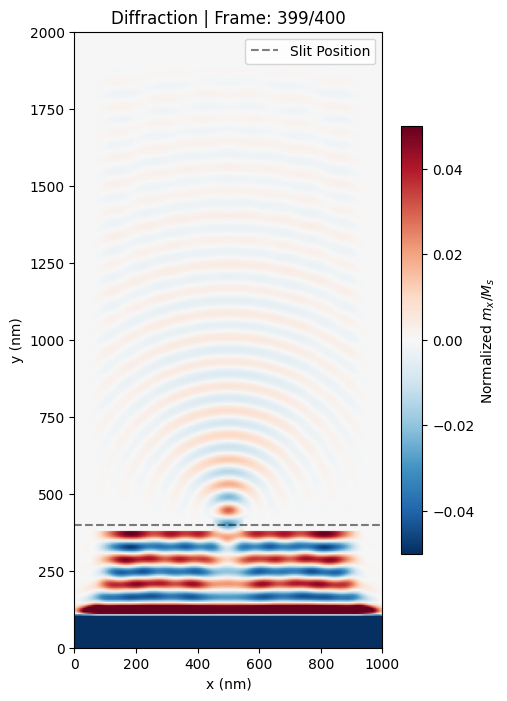

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob, os
import oommfpy as op
from tqdm import tqdm

# --- 1. 配置参数 ---
data_dir = r'D:\oommf21a2\sw_diffraction'
# 这里的 glob 模式建议写得具体一点，防止读入其他无关 omf 文件
files = sorted(glob.glob(os.path.join(data_dir, 'sw_diffraction*.omf')))
gif_path = os.path.join(data_dir, 'mx_diffraction_animation.gif')

if not files:
    raise FileNotFoundError(f"在路径 {data_dir} 下未找到 .omf 文件。")

# 物理常量与网格信息 (从第一帧读取)
m0 = op.MagnetisationData(files[0])
nx, ny = m0.nx, m0.ny
Ms_value = 8e5  # 对应 MIF 中的 Ms 值
# 设定绘图物理边界 (单位: nm)
extent = [0, 1000, 0, 2000] 

# --- 2. 初始化画布 ---
fig, ax = plt.subplots(figsize=(6, 8), dpi=100)

def get_normalized_mx(file_path):
    """读取并归一化 mx 分量"""
    m = op.MagnetisationData(file_path)
    # oommfpy 数据形状通常为 (nodes, dim)，需要 reshape 为 (ny, nx)
    data = m._generate_data()
    mx = data[:, 0].reshape((ny, nx)) 
    return mx / Ms_value

# 初始帧预取
mx_initial = get_normalized_mx(files[0])

# 设置色彩映射。vmin/vmax 设置为 0.05 表示显示 Ms 的 5% 偏转。
# 如果波信号较弱，可以调小这个值（例如 0.01）
im = ax.imshow(mx_initial, origin='lower', extent=extent,
               cmap='RdBu_r', vmin=-0.05, vmax=0.05, aspect='equal')

# 绘制狭缝屏障辅助线 (MIF 中设置在 yrel=0.2 处，即 400nm)
ax.axhline(400, color='black', lw=1.5, ls='--', alpha=0.5, label='Slit Position')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label(r'Normalized $m_x / M_s$')
ax.set_title("Spin-wave Diffraction")
ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.legend(loc='upper right')

# --- 3. 动画更新函数 ---
pbar = tqdm(total=len(files), desc="Processing Frames")

def update(frame):
    current_file = files[frame]
    mx_data = get_normalized_mx(current_file)
    im.set_array(mx_data)
    
    # 尝试从文件名或索引获取进度
    ax.set_title(f'Diffraction | Frame: {frame}/{len(files)}')
    
    pbar.update(1)
    return [im]

# --- 4. 生成与保存 ---
# frames 跳过前几帧（通常是初始态）
ani = animation.FuncAnimation(fig, update, frames=range(len(files)), blit=True)

print(f"正在生成动画，请稍候...")
writer = animation.PillowWriter(fps=15)
ani.save(gif_path, writer=writer)

pbar.close()
print(f"\n✅ 处理完成！")
print(f"动画保存至: {gif_path}")

# 最后显示一下最终帧（可选）
plt.show()